In [1]:
import glworia.load_interp
from glworia.load_interp import *

In [2]:
from importlib import reload

In [3]:
reload(glworia.load_interp)
from glworia.load_interp import *

In [17]:
lp_name = 'kappa'

settings = {
    'lens_param_name': lp_name,
    'y_low': 0.1,
    'y_high': 5.0,
    lp_name + '_low': 0.1,
    lp_name + '_high': 1.9,
    'N_grid': 31,
    'N_grid_strong': 61,
    'N_crit': 61,
    'N': 200,
    'lens_model_name': 'gSIS',

    'T0_max': 1000,

    'y_low_im': 0.1,
    'y_high_im': 5.0,
    lp_name + '_low_im': 0.1,
    lp_name + '_high_im': 1.9,
    'N_grid_im': 1001,
    'N_crit_im': 1001,
}

In [18]:
def strong_lens_cond_override_gSIS(strongly_lensed, y_interp, kappa_interp):
    if np.abs(kappa_interp - 1.) < 1e-15:
        if y_interp < 1.:
            strongly_lensed = True
        else:
            strongly_lensed = False
    return strongly_lensed

In [19]:
interpolators = load_interpolators('./interpolation', **settings)

In [20]:
w_interp = np.linspace(0.001, 1e4, 10**4)

In [88]:
y_interp = 0.1
lp_interp = 0.1

In [89]:
F, F_g, partitions, T_im, mu_im, u0, u1, u2, u3, um = F_interp(w_interp, y_interp, lp_interp, interpolators, settings,
             return_geom = True, 
             strong_lens_cond_override = strong_lens_cond_override_gSIS
             )

/home/markc/glworia/glworia/glworia/load_interp.py:210: RuntimeWarning: divide by zero encountered in divide
  return (1 + np.tanh((x - x0)/a))/2


In [90]:
T_im

[0, 0, 0]

In [91]:
mu_im

[0, 0, array(118.380657)]

In [92]:
partitions

array([  0.        ,  13.14696057, 262.93921134])

In [93]:
F

array([ 3.12701484-0.0486247j ,  3.66341729-0.53487215j,
        4.05978491-0.85918829j, ..., 10.88028754+0.j        ,
       10.88028754+0.j        , 10.88028754+0.j        ])

In [8]:
import matplotlib.pyplot as plt

/home/mcheung1/Lensing/Glworia_jax/glworia_jax/glworia/load_interp.py:186: RuntimeWarning: divide by zero encountered in divide
  return (1 + np.tanh((x - x0)/a))/2


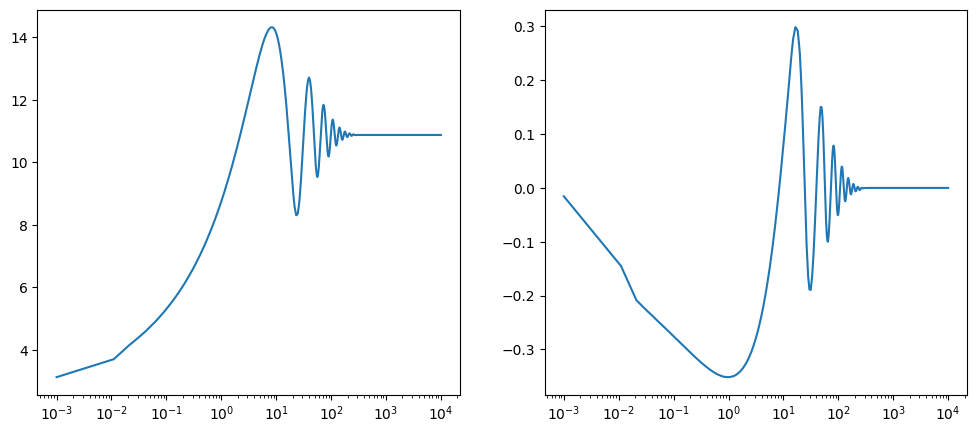

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].semilogx(w_interp, np.abs(F))
# axs[0].semilogx(w_interp, np.abs(F_g), alpha = 0.5)
axs[1].semilogx(w_interp, np.angle(F))

In [54]:
F_scale = np.max(np.abs(F-1))/2

(0.001, 10.0)

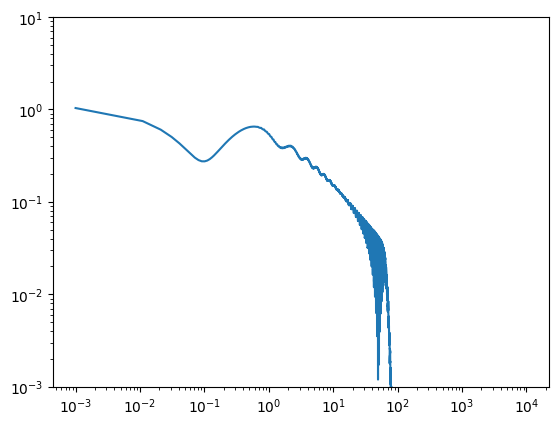

In [55]:
fig, ax = plt.subplots()
ax.loglog(w_interp, np.abs((F-F_g)/F_scale))
ax.set_ylim(1e-3, 1e1)